In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/kalapa

/content/drive/My Drive/kalapa


In [ ]:
!pip install feature_engine
!pip install unidecode

     |████████████████████████████████| 9.5MB 11.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 245kB 3.7MB/s 


In [ ]:
from itertools import combinations

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import warnings

import lightgbm as lgb
from unidecode import unidecode
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from feature_engine import categorical_encoders as ce

from itertools import combinations
from datetime import datetime
from contextlib import contextmanager

In [ ]:
lgbm_param = {'boosting_type': 'gbdt', 
              'colsample_bytree': 0.6602479798930369, 
              'is_unbalance': False, 
              'learning_rate': 0.01,
              'max_depth': 15, 
              'metric': 'auc', 
              'min_child_samples': 25, 
              'num_leaves': 100,
              'objective': 'binary', 
              'reg_alpha': 0.4693391197064131, 
              'reg_lambda': 0.16175478669541327, 
              'subsample_for_bin': 70000}

NUM_BOOST_ROUND= 10000

DROP = ["gioiTinh","info_social_sex", 'currentLocationCity', 'currentLocationName', 'homeTownCity', 'homeTownName'] + [f"Field_{c}" for c in [11, 14, 15, 16, 17, 18, 24,25, 26, 30, 31, 32, 33, 34,35, 37,40,45, 46, 48,49, 52, 56, 57, 68]]
DATE = ["Field_{}".format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 32, 33, 34, 35, 40]]
DATETIME = ["Field_{}".format(i) for i in [1, 2, 43, 44]]

In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

def lgb_gini(y_pred, dataset_true):
    y_true = dataset_true.get_label()
    return 'gini', Gini(y_true, y_pred), True

In [ ]:
def subtract_date(date1,date2, df):
    df[date1] = pd.to_datetime(df[date1], infer_datetime_format=True)
    df[date2] = pd.to_datetime(df[date2], infer_datetime_format=True)
    df[date1+date2] = (df[date2] - df[date1]).dt.days
    
def process_ngaySinh(s):
    if s != s:
        return np.nan
    try:
        s = int(s)
    except ValueError:
        s = s.split(" ")[0]
        
    return datetime.strptime(str(s)[:6], "%Y%m")

def datetime_normalize(s):
    if s != s:
        return np.nan
    s = s.split(".")[0]
    if s[-1] == "Z":
        s = s[:-1]
        
    date, time = s.split("T")
    datetime_obj = datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    return datetime_obj

def date_normalize(s):
    if s != s:
        return np.nan
    
    try:
        datetime_obj = datetime.strptime(s, "%m/%d/%Y")
    except:
        datetime_obj = datetime.strptime(s, "%Y-%m-%d")
        
    return datetime_obj
  
def process_datetime_cols(df):
    cat_cols = []
    for col in DATETIME:
        df[col] = df[col].apply(datetime_normalize)
        
    for col in DATE:
        if col == "Field_34":
            continue
        df[col] = df[col].apply(date_normalize)

    df["Field_34"] = df["Field_34"].apply(process_ngaySinh)
    df["ngaySinh"] = df["ngaySinh"].apply(process_ngaySinh)
    
    cat_cols += DATE + DATETIME
    for col in DATE + DATETIME:
        #df[col].fillna(0)
        df[col] = df[col].dt.strftime('%d-%m-%Y')
    
    subtract_date('Field_5','Field_6',df)
    subtrac_List = ['Field_1', 'Field_2', 'Field_43', 'Field_44', 'Field_7','Field_8', 'Field_9']
    subtract_2C = list(combinations(subtrac_List, 2))
    for l in subtract_2C:
        subtract_date(l[0],l[1],df)
      
    for cat in ['F', 'E', 'C', 'G', 'A']:
        subtract_date(f'{cat}_startDate', f'{cat}_endDate', df)
    print(df.shape) 
    return df
  
def str_normalize(s):
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s

def process_location(df):
    for col in ["currentLocationLocationId", "homeTownLocationId", "currentLocationLatitude", "currentLocationLongitude", 
                   "homeTownLatitude", "homeTownLongitude"]:
        df[col].replace(0, np.nan, inplace=True)

#     df["currentLocationLocationId"] = df["currentLocationLocationId"].apply(str_normalize).astype("category")
#     df["homeTownLocationId"] = df["homeTownLocationId"].apply(str_normalize).astype("category")

    return df

    
def combine_gender(s):
    x, y = s
    return x if x != None else y if y != None else None

def process_gender(df):
    df["gender"] = df[["gioiTinh", "info_social_sex"]].apply(combine_gender, axis=1).astype("category")
    return df

def process_ordinal(df):        
    df["subscriberCount"].replace(0, np.nan, inplace=True)
    df["friendCount"].replace(0, np.nan, inplace=True)
    
    df["Field_13"] = df["Field_13"].apply(lambda x: 1 if x == x else 0)
    df["Field_38"] = df["Field_38"].map({0: 0.0, 1: 1.0, "DN": np.nan, "TN": np.nan, "GD": np.nan})
    df["Field_62"] = df["Field_62"].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5, "Ngoài quốc doanh Quận 7": np.nan})
    df["Field_47"] = df["Field_47"].map({"Zezo": 0, "One": 1, "Two": 2, "Three": 3, "Four": 4})
    
    df["Field_27"] = df["Field_27"].replace({0.0: np.nan})
    df["Field_28"] = df["Field_28"].replace({0.0: np.nan})
        
    for col in df.columns:
        if df[col].dtype.name == "object":
            df[col] = df[col].apply(str_normalize).astype("category")
            
    return df

def transform(df):
    df = process_datetime_cols(df)
    df = process_gender(df)
    df = process_location(df)
    df = process_ordinal(df)
    df["null_sum"] = df.isnull().sum(axis=1)
    return df.drop(DROP, 1)

In [ ]:
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, recall_score, classification_report
import seaborn as sns
from lightgbm import LGBMClassifier


# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
    
def display_roc_curve(y_, oof_preds_,sub_preds_,folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = []
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = 2 * auc(fpr, tpr) -1
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = 2 * auc(fpr, tpr) -1
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC mean = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('roc_curve_r.png')

In [ ]:
def kfold(train_df, test_df, y_label, stratified = False, debug= False):
    num_folds = 5
    # Divide in training/validation and test data
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    gc.collect()
    # Cross validation model
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=500)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['label','id']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], y_label)):        
        train_x, train_y = train_df[feats].iloc[train_idx], y_label.iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], y_label.iloc[valid_idx]

        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=128,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1
        )

        clf.fit(train_x, train_y.ravel(), eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc', verbose= 1000, early_stopping_rounds= 200)

        oof_pred = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        
        pred = clf.predict(valid_x, num_iteration=clf.best_iteration_)
        print('F1 Score: ' + str( f1_score(valid_y, pred) ))
        print('Recall Score: ' + str( recall_score(valid_y, pred) ))
        
        sub_pred = clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        oof_preds[valid_idx] = oof_pred
        sub_preds += sub_pred
                
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(y_label, oof_preds))
    
    folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(train_df[feats], y_label)]
    display_roc_curve(y_=y_label,oof_preds_=oof_preds,sub_preds_ = sub_preds, folds_idx_=folds_idx)
    display_importances(fold_importance_df)

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/kalapa/dataset/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/kalapa/dataset/test.csv')
for col in DATE + DATETIME:
    df_train[col].fillna(0)
    df_test[col].fillna(0)
df_all = df_train.drop(['label'], 1).append(df_test)
    #df_train.fillna(-1, inplace=True)
    #df_test.fillna(-1, inplace=True)
    #df_train = df_train.replace([np.inf, -np.inf], np.nan).dropna(axis=0,inplace = True)
    #df_test = df_test.replace([np.inf, -np.inf], np.nan).dropna(axis=0, inplace = True)   
    
with timer("Preprocess"):
    df_all_fe = transform(df_all.copy())
    print("Bureau df shape:", df_all_fe.shape)
    df_all_fe['Age'] = df_all_fe.ngaySinh.apply(lambda x: 2020 - x.year)
    df_all_fe = df_all_fe.drop('ngaySinh', axis = 1)
    cols_select = [x for x in df_all_fe.columns if x not in DATE + DATETIME  + [f'{cat}_endDate' for cat in ['F', 'E', 'C', 'G', 'A']] + [f'{cat}_startDate' for cat in ['F', 'E', 'C', 'G', 'A']]]
    df_fe = df_all_fe[cols_select]
    df_fe.replace([np.inf, -np.inf], -99999, inplace=True)

    y_label = df_train["label"]
    train_fe = df_fe[df_fe["id"] < df_train.shape[0]]
    test_fe = df_fe[df_fe["id"] >= df_train.shape[0]]

    # Label-Encoding
    lbl = LabelEncoder()
    for col in df_fe.columns:
      if df_fe[col].dtype.name == "category":
        train_fe[col] = train_fe[col].astype(str)
        test_fe[col] = test_fe[col].astype(str)
        encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency')
        train_fe[col] = train_fe[col].fillna('None')
        test_fe[col] = test_fe[col].fillna('None')

        # Only take the common values in Train/Test set
        common_vals = list(set(train_fe[col]).intersection(set(test_fe[col])))

        # Take if vals appeared both 5 times
        common_vals = set(train_fe[col].value_counts()[train_fe[col].value_counts() > 4].index).intersection(test_fe[col].value_counts()[test_fe[col].value_counts()>4].index)

        # Replace not-common values with "Missing" or np.nan
        train_fe.loc[~train_fe[col].isin(common_vals), col] = 'Missing'
        test_fe.loc[~test_fe[col].isin(common_vals), col] = 'Missing'

        # Implement LE
        lbl.fit(train_fe[col].tolist() + test_fe[col].tolist())
        train_fe[col] = lbl.transform(train_fe[col])
        test_fe[col] = lbl.transform(test_fe[col])

    print(train_fe.shape)
    print(test_fe.shape)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(73411, 221)
Bureau df shape: (73411, 192)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

(53030, 173)
(20381, 173)
Preprocess - done in 15s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting LightGBM. Train shape: (53030, 173), test shape: (20381, 173)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[750]	valid_0's binary_logloss: 0.459263	valid_0's auc: 0.846846	valid_1's binary_logloss: 0.534379	valid_1's auc: 0.740641
F1 Score: 0.4616292798110979
Recall Score: 0.34910714285714284
Fold  1 AUC : 0.740641
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[794]	valid_0's binary_logloss: 0.456078	valid_0's auc: 0.850594	valid_1's binary_logloss: 0.530503	valid_1's auc: 0.752187
F1 Score: 0.4492579221821099
Recall Score: 0.33343256921702885
Fold  2 AUC : 0.752187
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[763]	valid_0's binary_logloss: 0.458197	valid_0's auc: 0.848598	valid_1's binary_logloss: 0.52752	valid_1's auc: 0.751297
F1 Score: 0.46264482620854974
Recall Score: 0.34474545995832095
Fold  3 AUC : 0.751297
Train

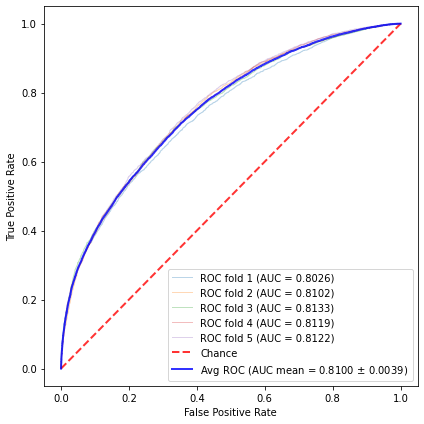

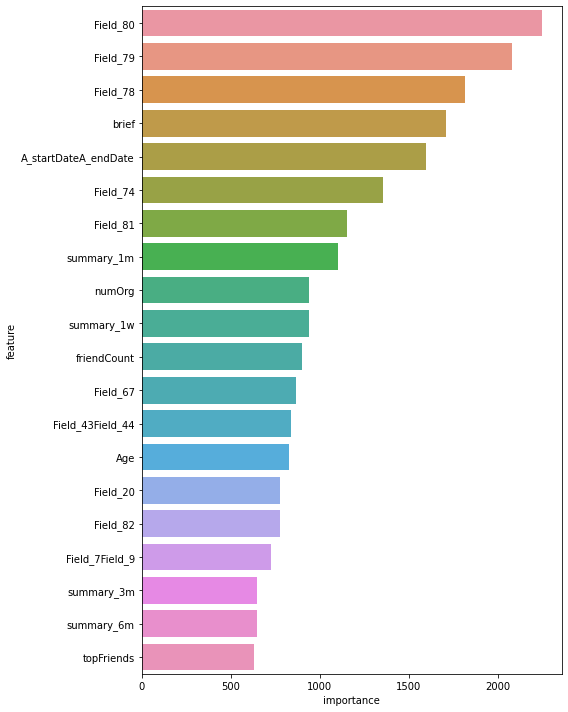

In [ ]:
with timer("Kfold"):
    preds = kfold(train_fe,test_fe,y_label)

In [ ]:
import joblib

joblib.dump(model,'model.pkl')


In [ ]:
loaded_model = joblib.load('./model.pkl')

In [ ]:
from sklearn.metrics import classification_report

y_pred = loaded_model.predict(TRAIN)

In [ ]:
scores = [0.8026, 0.8102, 0.8133, 0.8119, 0.8122]


In [ ]:
np.std(scores)

0.003850506460194566

In [ ]:
scores[0]

0.8202

0.5072735159107776